In [1]:
from cltk.data.fetch import FetchCorpus
corpus_downloader = FetchCorpus(language="lat")
corpus_downloader.import_corpus("lat_models_cltk")

import pandas as pd
from src.corpus import load_corpus
documents = load_corpus()

dates = pd.read_csv('LatLibDates-Filtered.csv')
documents_with_dates = []
all_dates = []

for doc in documents:
    title = doc[0][39:] # Chop off the file name
    if (dates['V1'] == title).any():
        date = dates[dates['V1'] == title].values[0][1]
        if date <= 13:
            # Convert to year
            date = -700 + date * 100
            all_dates.append(date)
            documents_with_dates.append(doc)
    else:
        print(f"Couldn't find {title}")

# Sort documents by date and split into bins
sorted_docs = sorted(zip(documents_with_dates, all_dates), key=lambda pair: pair[1])

num_bins = 10
bin_size = (max(all_dates) - min(all_dates))/num_bins
bin_counts = [0] * num_bins
current_bin = 1

# Separate docs into bins
for (doc, date) in sorted_docs:
    if date > (current_bin * bin_size) + min(all_dates):
        # Move to the next bin
        current_bin += 1
    bin_counts[current_bin - 1] += 1
bin_counts    

Loading corpus...
Loaded 2141 texts.
Couldn't find epistaustras.txt
Couldn't find asserius.txt
Couldn't find appverg.catalepton.txt
Couldn't find xanten.txt
Couldn't find fragmentumlaurentianum.txt
Couldn't find dares1.txt
Couldn't find inscriptions.txt
Couldn't find appvergculex.txt
Couldn't find epitaphs.txt
Couldn't find cato.dis.txt
Couldn't find pulchracomis.txt
Couldn't find hymni.txt
Couldn't find baldo.txt
Couldn't find columba2.txt
Couldn't find diravi.txt
Couldn't find lucernarium.txt
Couldn't find appvergcomp.txt
Couldn't find carmenarvale.txt
Couldn't find columba1.txt
Couldn't find valesianus1.txt
Couldn't find index.txt
Couldn't find nivis.txt
Couldn't find carmensaliare.txt
Couldn't find dares.txt
Couldn't find appverg.aetna.txt
Couldn't find valesianus2.txt
Couldn't find appverg.ciris.txt
Couldn't find liberpontificalis1.txt
Couldn't find indices.txt
Couldn't find walton.txt
Couldn't find creeds.txt
Couldn't find donation.txt
Couldn't find precatio.txt
Couldn't find cae

[2, 2, 32, 235, 446, 141, 65, 76, 193, 158]

In [3]:
# Preprocess documents
from cltk.tokenizers.lat.lat import LatinWordTokenizer
from cltk.lemmatize.lat import LatinBackoffLemmatizer
from cltk.stops.words import Stops
from tqdm.notebook import tqdm

stops = Stops(iso_code='lat').stops + ['punc', 'quod', 'se', 'sunt', 'esse', 'tibi', 'mihi', 'te', 'quid', 'me', 'hoc', 'cum2', 'meus', 'tuus', 'the', 'ejus', 'dig', 'iste', 'nunc', 'ed', 'ch', 'vel', 'cj', 'aa', 'pp', 'cth']

tokenizer = LatinWordTokenizer()
lemmatizer = LatinBackoffLemmatizer()

tokenized_documents = []
for document, date in tqdm(sorted_docs):
    text = document[1]
    tokenized = [token.lower() for token in tokenizer.tokenize(document[1])]
    lemmatized = [lemma[1] for lemma in lemmatizer.lemmatize(tokenized)]
    lemmatized = [token for token in lemmatized if token not in stops]
    tokenized_documents.append(lemmatized)

tokenized_documents[0]

  0%|          | 0/1350 [00:00<?, ?it/s]

['duodecim',
 'tabularis',
 'lex',
 'duodecim',
 'tabularis',
 'lex',
 'tabula',
 'eo',
 'ius',
 'voco',
 'eo',
 'ni',
 'eo',
 'antestamino',
 'em',
 'capito',
 'calvo',
 'pedo1',
 'struo',
 'manus',
 'endo',
 'jacio',
 'morbus',
 'aevitasve',
 'vitium',
 'ex-scio',
 'jumentum',
 'do',
 'nolo',
 'arcera',
 'sterno',
 'assiduus2',
 'vindex',
 'assiduus1',
 'proletarius',
 'cieo',
 'volo1',
 'vindex',
 'nex',
 'fortis',
 'sano',
 'res',
 'pacunt',
 'oro',
 'ni',
 'pacunt',
 'comitium',
 'forum',
 'meridio',
 'caussam',
 'coiciunto',
 'com',
 'peroro',
 'ambo',
 'praesens',
 'meridio',
 'praesens',
 'lito',
 'addico',
 'ambo',
 'praesens',
 'sol',
 'occido',
 'superus',
 'tempestas',
 'vado1',
 'subvades',
 'tabula',
 '<actor',
 'dico2',
 'sponsio',
 'do',
 'oportet',
 'aio',
 'quando',
 'nego',
 'praetor',
 'judico',
 'arbiter',
 'postulo',
 'uti',
 'des.',
 '. . .',
 'morbus',
 'sonticus',
 'status',
 'dies',
 'hostis',
 'judicium',
 'arbiter',
 'reor',
 'dies',
 'diffindo',
 'testimoni

In [86]:
from collections import defaultdict
import numpy as np
from sklearn import decomposition, feature_extraction
from tqdm.notebook import tqdm

# remove words that appear only once
frequency = defaultdict(int)
for text in tokenized_documents:
    for token in text:
        frequency[token] += 1
        
vocabulary = [token for token in frequency if frequency[token] > 1]
        

tfidf = feature_extraction.text.TfidfTransformer()
    
def nmf(docs, terms, k):
    # Create document term matrix
    print("Creating document term matrix...")
    doc_term = np.zeros((len(docs), len(terms)))
    for i, doc in tqdm(enumerate(docs), total=len(docs)):
        for j, term in enumerate(terms):
            doc_term[i, j] = doc.count(term)
            
    doc_term = tfidf.fit_transform(doc_term)
    
    print("Applying NMF...")
    model = decomposition.NMF(n_components=k, init='nndsvd', random_state=0)
    W = model.fit_transform(doc_term)
    H = model.components_
    return W, H

W, H = nmf(tokenized_documents[:10], vocabulary, 8)
print(f"W (docs-topics): {W.shape}")
print(f"H (topics-terms): {H.shape}")

Creating document term matrix...


  0%|          | 0/10 [00:00<?, ?it/s]

Applying NMF...
W (docs-topics): (10, 8)
H (topics-terms): (8, 78734)


In [87]:
# Skip the first 2 bins, too small!
window_topic_models = []

cur_index = 4
for bin_count in tqdm(bin_counts[2:]):
    window_docs = tokenized_documents[cur_index:cur_index + bin_count]
    W, H = nmf(window_docs, vocabulary, 8)
    window_topic_models.append((W, H))

  0%|          | 0/8 [00:00<?, ?it/s]

Creating document term matrix...


  0%|          | 0/32 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/235 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/446 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/141 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/65 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/76 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/193 [00:00<?, ?it/s]

Applying NMF...
Creating document term matrix...


  0%|          | 0/158 [00:00<?, ?it/s]

Applying NMF...


In [89]:
import pickle

with open("nmf_window_topic_models.pkl", "wb") as f:
    pickle.dump(window_topic_models, f)
    
# with open('nmf_window_topic_models.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

In [90]:
num_terms = 10
B = np.zeros((8 * 8, len(vocabulary))) # (Num bins x num topics, num terms)

i = 0
for W, H in window_topic_models:
    for row in H:
        # 0 out any items besides the top t
        threshold = np.partition(row, -num_terms)[-num_terms]
    
        # Set all elements smaller than the threshold to 0
        row[row < threshold] = 0
        
        # Add to B matrix
        B[i] = row
        i += 1

# Delete all columns with only 0
idx = np.argwhere(np.all(B[..., :] == 0, axis=0))
B = np.delete(B, idx, axis=1)

flattened_idx = idx.flatten()
reduced_vocab = [v for (i, v) in enumerate(vocabulary) if i not in idx]

print(f"B matrix: {B.shape}")

B matrix: (64, 171)


In [91]:
# Run NMF to get dynamic topic model

dynamic_model = decomposition.NMF(n_components=8, init='nndsvd', random_state=0)
U = dynamic_model.fit_transform(B)
V = dynamic_model.components_

print(f"U (windowtopics-dynamictopics): {U.shape}")
print(f"V (dynamictopics-terms): {V.shape}")

U (windowtopics-dynamictopics): (64, 8)
V (dynamictopics-terms): (8, 171)


In [102]:
dynamic_topic_terms = []

# Determine terms for all dynamic topics
for v in V:
    sorted_indices = np.argsort(v)
    
    # Return the indices of the top n values
    top_indices = sorted_indices[-10:]

    top_terms = [reduced_vocab[i] for i in top_indices]
    dynamic_topic_terms.append(top_terms)
    
dynamic_topic_terms

[['caesar',
  'bellum',
  'quiris',
  'consul',
  'romanus',
  'omnis',
  'antonius',
  'senatus',
  'res',
  'publicus'],
 ['res',
  'malus',
  'causa',
  '-ne',
  'iudex',
  'scio',
  'do',
  'homo',
  'dico',
  'facio'],
 ['py.', 'gn.', 'ge.', 'facio', 'ph.', 'do', 'sy', 'th', 'pa', 'ch.'],
 ['facio',
  'aulus',
  'attico',
  'sal',
  'cicero',
  'res',
  'video',
  'littera',
  'scribo',
  'scr.'],
 ['ignis',
  'terra',
  'magnus',
  'dico',
  'natura',
  'multus',
  'corpus',
  'video',
  'omnis',
  'res'],
 ['res',
  'locus',
  'hostis',
  'miles',
  'oppidum',
  'magnus',
  'omnis',
  'legio',
  'castrum',
  'caesar'],
 ['casus',
  'declinatio',
  'habeo',
  'genus',
  'similis',
  'declino',
  'verbum',
  'alius',
  'analogia',
  'dico'],
 ['consul',
  '-ne',
  'urbs',
  'thos',
  'titus',
  'condio',
  'livi',
  'aduersus',
  'livy',
  'periocha']]

In [103]:
# Assign each window topic to the highest weighted dynamic topic
windowtopic_to_dynamic_topics = np.argmax(U, axis=1)
windowtopic_to_dynamic_topics

array([1, 2, 0, 2, 1, 1, 2, 0, 1, 3, 0, 5, 4, 1, 1, 4, 0, 1, 7, 3, 5, 4,
       2, 1, 0, 4, 1, 3, 4, 6, 1, 2, 4, 1, 0, 6, 2, 1, 1, 1, 4, 4, 1, 6,
       2, 1, 0, 0, 4, 3, 0, 1, 4, 6, 4, 5, 4, 4, 3, 1, 4, 6, 0, 0])

In [109]:
# Determine which dynamic topic each document corresponds to
# For each timestep, create a new matrix document x dynamic topics

windows_dynamic_topic_model = []

for timestep in range(len(window_topic_models)):
    W, H = window_topic_models[timestep]
    
    document_dynamictopics = np.zeros((len(W), 8))
    for document_index in range(len(W)):
        for topic_index in range(W.shape[1]):
            # Corresponding topic index (going from 64 window topics to 8 dynamic topics)
            dynamic_topic_index = windowtopic_to_dynamic_topics[(timestep + 1) * topic_index]
            document_dynamictopics[document_index, dynamic_topic_index] += W[document_index, topic_index]
    windows_dynamic_topic_model.append(document_dynamictopics)
    
windows_dynamic_topic_model[1].shape

(235, 8)

In [135]:
import pyLDAvis

# Calculate normalized document x dynamic topic matrix
doc_topic = np.vstack(windows_dynamic_topic_model)
doc_topic_row_sums = np.sum(doc_topic, axis=1)
doc_topic = doc_topic / doc_topic_row_sums[:, np.newaxis]

doc_lengths = [len(doc) for doc in tokenized_documents[4:]]

all_doc_term = np.zeros((len(reduced_vocab)))
for doc in tqdm(tokenized_documents[4:], total=len(tokenized_documents[4:])):
    for j, term in enumerate(reduced_vocab):
        all_doc_term[j] += doc.count(term)

vis_dtm = pyLDAvis.prepare(topic_term_dists=V, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=reduced_vocab, term_frequency=all_doc_term)
pyLDAvis.save_json(vis_dtm, './results/NMF/intertopic.json')
pyLDAvis.display(vis_dtm)

/Users/milesper/miniforge3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/milesper/miniforge3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/milesper/miniforge3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


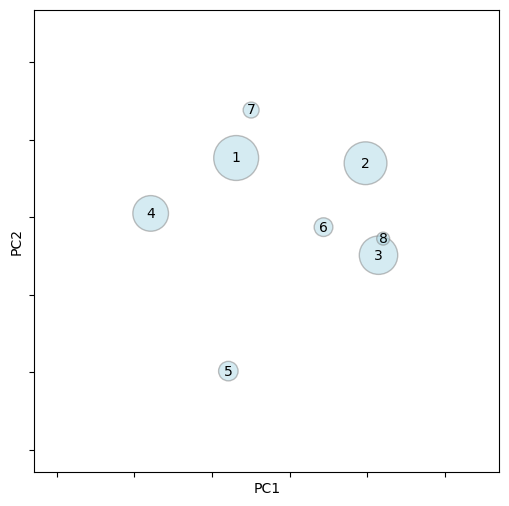

In [136]:
from src.convert_ldavis_to_pyplot import convert_ldavis_to_pyplot

convert_ldavis_to_pyplot('./results/NMF/intertopic.json', './results/NMF/intertopic.eps')

In [150]:
# For each dynamic topic, compute the number of documents at each timestep with that topic as the most likely
dynamic_topics_frequency_overtime = np.zeros((8, 8))

for window_index in range(len(windows_dynamic_topic_model)):
    top_topics = np.argmax(windows_dynamic_topic_model[window_index], axis=1)
    for topic_index in range(8):
        topic_count = np.count_nonzero(top_topics == topic_index)
        dynamic_topics_frequency_overtime[topic_index, window_index] = topic_count
        
dynamic_topics_frequency_overtime

array([[  6.,  61.,   0.,  35.,  14.,   6.,  34.,  49.],
       [ 17., 143.,  47.,  77.,  27.,  27., 103.,  53.],
       [  9.,  14., 138.,   0.,   0.,  18.,   0.,   0.],
       [  0.,   0.,  37.,   0.,   0.,   0.,   6.,   0.],
       [  0.,  17., 162.,  19.,  15.,  21.,  39.,  56.],
       [  0.,   0.,   0.,  10.,   6.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   3.,   0.,  11.,   0.],
       [  0.,   0.,  62.,   0.,   0.,   4.,   0.,   0.]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


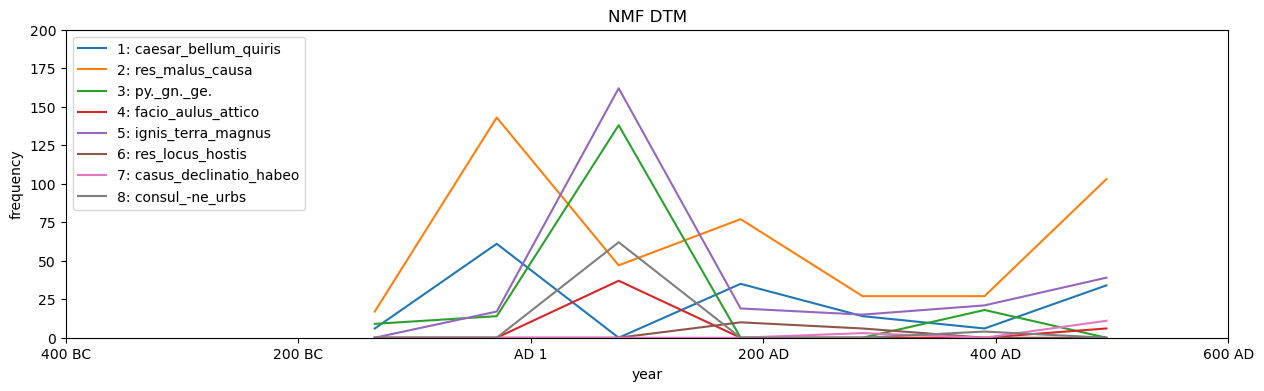

In [158]:
import matplotlib.pyplot as plt

# Create the x axis values
# We multiply by 10 and then divide because range doesn't support non-integer steps
x = [val/10 for val in range(-4490 + 1049, 6000 + 1049, 1049)]

plt.rcParams["figure.figsize"] = (15,4)

# Plot each topic's frequency over time
for topic in range(8):
    label = '_'.join(dynamic_topic_terms[topic][:3])
    label = f"{topic + 1}: {label}"
    plt.plot(x[2:-1], dynamic_topics_frequency_overtime[topic, :-1], label=label)

plt.axis([-400, 600, 0, 200])

ticks = plt.xticks()[0]
labels = []
for tick in ticks:
    if tick < 0:
        labels.append(f"{int(abs(tick))} BC")
    elif tick == 0:
        labels.append("AD 1")
    else:
        labels.append(f"{int(tick)} AD")
plt.xticks(ticks, labels)


plt.legend()
plt.xlabel('year')
plt.ylabel('frequency')
plt.title('NMF DTM')

plt.savefig("nmf_topics_over_time.eps", format = 'eps', bbox_inches='tight')

plt.show()

In [159]:
from src.embedder import topic_coherence

total = 0
for i in range(5):
    print(f"Topic {i}: {topic_coherence([term[0] for term in dynamic_topic_terms[i]])}")
    total += topic_coherence([term[0] for term in dynamic_topic_terms[i]])

total / 5

/Users/milesper/miniforge3/lib/python3.10/site-packages/transformers/image_utils.py:222: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(self, image, size, resample=PIL.Image.BILINEAR, default_to_square=True, max_size=None):


‎𐤀 CLTK version '1.1.6'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinLexiconProcess`.
Topic 0: 0.2850413117143843
Topic 1: 0.296328733364741
Topic 2: 0.33892722030480704
Topic 3: 0.333163289560212
Topic 4: 0.28304452035162186


0.30730101505915325

In [160]:
from src.embedder import mean_pairwise_jaccard

mean_pairwise_jaccard([[term[0] for term in dynamic_topic_terms[i]] for i in range(5)])

0.3692557442557443